# Visualizing MISP Data with NetworkX

Setup the required dependencies and variables

In [2]:
from pymisp import PyMISP
import jmespath
import networkx as nx
import matplotlib.pyplot as plt

# MISP configuration
MISP_URL = 'https://localhost'
MISP_KEY = 'gZiXERMWQGlO9ILzny0uvKC01X63P7eSjAW0EN3Y'
EVENT_ID = 7

Connect to MISP

In [3]:
misp = PyMISP(MISP_URL, MISP_KEY, ssl=False)    

/home/bikram/Git/cti-platform/orchestration/venv/lib64/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
The version of PyMISP recommended by the MISP instance (2.4.171) is newer than the one you're using now (2.4.170.2). Please upgrade PyMISP.
/home/bikram/Git/cti-platform/orchestration/venv/lib64/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/bikram/Git/cti-platform/orchestration/venv/lib64/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being 

Get MISP Event data

In [4]:
event = misp.get_event(7)

/home/bikram/Git/cti-platform/orchestration/venv/lib64/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Initialize a graph and add the Event as a node

In [5]:
# Create an empty graph
G = nx.Graph()
G.add_node(event['Event']['uuid'], label='Event')

Define node types that need to be shown on the graph, along with their respective colors

In [6]:
node_colors = {
    'Event': 'red',
    'ip-dst': 'green',
    'AS': 'yellow',
    'domain': 'orange',
    'email': 'lightblue',
    'mitre-intrusion-set': 'red',
    'sector': 'red',
    'country': 'red'
    
}
shown_attributes = node_colors.keys()

Create nodes for all attributes contained within the MISP event

In [7]:
# Add main attributes
for attribute in event['Event']['Attribute']:
    if attribute['type'] in shown_attributes:
        G.add_node(attribute['value'], label=attribute['type'], info=attribute['value'])
        G.add_edge(event['Event']['uuid'], attribute['value'], relationship='related-to')

# Add object attributes (Enrichments)
for obj in event['Event']['Object']:
    objectRefAttrs = jmespath.search('[].Attribute.{value: value, type: type}', obj['ObjectReference'])
    for attribute in obj['Attribute']:
        if attribute['type'] in shown_attributes:
            G.add_node(attribute['value'], label=attribute['type'], info=attribute['value'])
            for refAttr in objectRefAttrs:
                if refAttr['type'] in shown_attributes and attribute['value'] != refAttr['value']:
                    G.add_node(refAttr['value'], label=refAttr['type'], info=refAttr['value'])
                    G.add_edge(attribute['value'], refAttr['value'], relationship='related-to')


Create nodes for Galaxy entities

In [8]:
for galaxy in event['Event']['Galaxy']:
    if galaxy['type'] in shown_attributes:
        for cluster in galaxy['GalaxyCluster']:
            G.add_node(cluster['value'], label=galaxy['type'], info=cluster['value'])
            G.add_edge(event['Event']['uuid'], cluster['value'], relationship='related-to')

* Map node labels to the `info` property 
* Setup node colors based on node types (`label` property)

In [9]:
node_labels = nx.get_node_attributes(G, 'info')
node_types = nx.get_node_attributes(G, 'label')
colors = [node_colors[node_types[node_attr]] for node_attr in node_types]

Create the Graph

/tmp/ipykernel_822918/1552278509.py:5: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(G, prog="fdp")


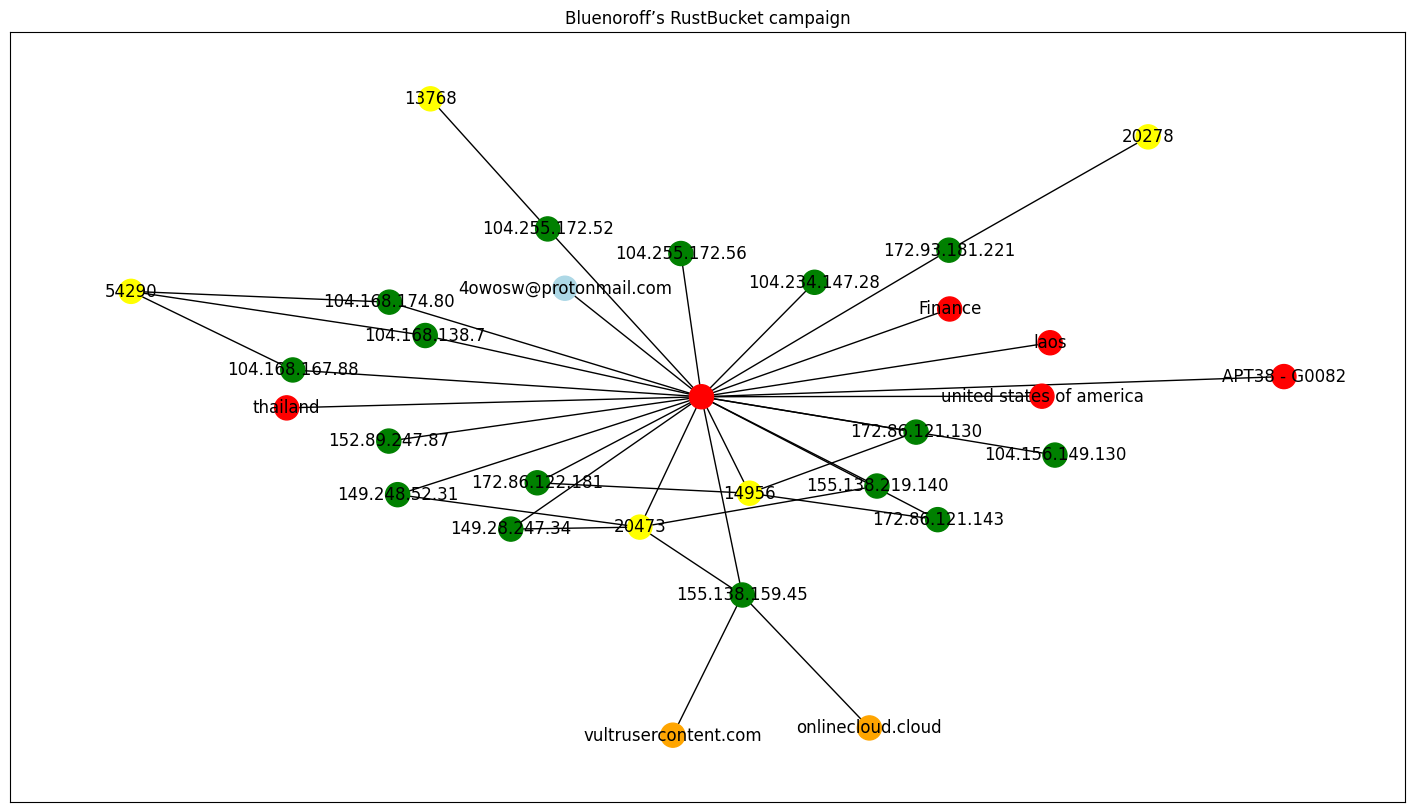

In [17]:
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
# from networkx.drawing.nx_agraph import graphviz_layout

pos = graphviz_layout(G, prog="fdp")
# nx.draw(G, pos)
plt.figure(figsize=(18, 10))
# plt.title(event['Event']['info'])
nx.draw_networkx(G, pos, with_labels=True, labels=node_labels, node_color=colors)
plt.title(event['Event']['info'])
plt.show()